In [1]:

# cd drive/MyDrive/Colab\ Notebooks/


In [2]:
# ls

# Imports + Setup

In [19]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random

In [20]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [21]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
DATA_DIR = "../../../data/Theoretical_VTDP"
# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [22]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time,filename):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    df["filename"] = filename
    return df

# Load and Combine Data

In [25]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue

    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping (unmatched):", fname)
        continue

    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params, filename=fname)
    dataframes.append(df)
    data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())

Skipping (unmatched): h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66146 entries, 0 to 66145
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  66146 non-null  int64  
 1   TC1_tip               66146 non-null  float64
 2   TC2                   66146 non-null  float64
 3   TC3                   66146 non-null  float64
 4   TC4                   66146 non-null  float64
 5   TC5                   66146 non-null  float64
 6   TC6                   66146 non-null  float64
 7   TC7                   66146 non-null  float64
 8   TC8                   66146 non-null  float64
 9   TC9                   66146 non-null  float64
 10  TC10                  66146 non-null  float64
 11  Theoretical_Temps_1   66146 non-null  float64
 12  Theoretical_

# H6 Only Dataset

In [ ]:
# dataframes = []
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith(".csv"):
#         continue

#     params = parse_filename_params(fname)
#     if params is None or params[3] is None:
#         print("Skipping (unmatched):", fname)
#         continue

#     h_val = params[0]
#     if h_val != h_map[6]:  # Only include h6 = 0.1575
#         print("Skipping (not h6):", fname)
#         continue

#     path = os.path.join(DATA_DIR, fname)
#     df = load_and_process_file(path, *params,filename=fname)
#     dataframes.append(df)
#     data = pd.concat(dataframes, ignore_index=True)
# print(data.info())
# print(data.head())


Skipping (not h6): h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_431s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_585s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_wr_surf0_368s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_115s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_wr_surf

# Preprocessing

In [26]:
# Preprocessing
theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
filenames = data["filename"].reset_index(drop=True)
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()
X["filename"] = filenames
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')
y_columns = y.columns

X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
)

train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
val_filenames = X.loc[X_val_raw.index, "filename"].unique().tolist()
test_filenames = X.loc[X_test_raw.index, "filename"].unique().tolist()

print("Train Files:", train_filenames)
print("Val Files:", val_filenames)
print("Test Files:", test_filenames)

# Scaling
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw)
X_val_scaled = X_scaler.transform(X_val_raw)
X_test_scaled = X_scaler.transform(X_test_raw)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled = y_scaler.transform(y_val_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

joblib.dump(X_scaler, "X_scaler.pkl")
joblib.dump(y_scaler, "y_scaler.pkl")

# Convert to tensors and create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_scaled, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Train Files: ['h6_flux88_abs0_surf0_689s - Sheet3_processed.csv', 'h6_flux88_abs20_surf0_longRun_612s - Sheet2_processed.csv', 'h6_flux78_abs0_surf0_450s - Sheet3_processed.csv', 'h6_flux88_abs0_surf1_newSalt_573s - Sheet2_processed.csv', 'h2_flux88_abs25_surf0_493s - Sheet1_processed.csv', 'h3_flux88_abs25_surf0_660s-Sheet1_processed.csv', 'h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv', 'h6_flux88_abs92_wr_surf0 _835s- Sheet1_processed.csv', 'h6_flux78_abs0_surf1_newSalt_851s - Sheet2_processed.csv', 'h6_flux88_abs92_surf0_630s - Sheet2_processed.csv', 'h3_flux88_abs90_surf0_692s-Sheet2_processed.csv', 'h6_flux73_abs0_surf1_754s - Sheet3_processed.csv', 'h6_flux88_abs0_surf0_longRun_762s - Sheet1_processed.csv', 'h2_flux88_abs92_surf0_115s - Sheet1_processed.csv', 'h6_flux88_abs20_surf0_389s - Sheet3_processed.csv', 'h6_flux88_abs0_surf0_longRun_643s - Sheet3_processed.csv', 'h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv', 'h6_flux78_abs0_surf0_523s - Sheet2_p

In [ ]:
# # Use if u want to see the filenames for each section of train,validation and test


# # 1. Extract input (X) and output (y) columns
# theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
# # Store filename separately
# filenames = data["filename"].reset_index(drop=True)

# # Drop filename before assigning to X and y
# X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()
# X["filename"] = filenames  # only attach to X, not y

# y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')


# X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
#     X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
# )
# X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
#     X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
# )

# train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
# val_filenames   = X.loc[X_val_raw.index, "filename"].unique().tolist()
# test_filenames  = X.loc[X_test_raw.index, "filename"].unique().tolist()

# print("Train Files:", train_filenames)
# print("Val Files:", val_filenames)
# print("Test Files:", test_filenames)


# # 2. Split into train, val, test before scaling
# # X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(X, y, test_size=0.3, random_state=SEED)
# # X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED)

# # 3. Scale using only training set statistics
# X_scaler = MinMaxScaler()
# X_train_scaled = X_scaler.fit_transform(X_train_raw)
# X_val_scaled   = X_scaler.transform(X_val_raw)
# X_test_scaled  = X_scaler.transform(X_test_raw)

# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train_raw)
# y_val_scaled   = y_scaler.transform(y_val_raw)
# y_test_scaled  = y_scaler.transform(y_test_raw)

# joblib.dump(X_scaler, "X_scaler.pkl")
# joblib.dump(y_scaler, "y_scaler.pkl")

# # 4. Convert to PyTorch tensors for training
# X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_val   = torch.tensor(X_val_scaled, dtype=torch.float32)
# X_test  = torch.tensor(X_test_scaled, dtype=torch.float32)

# y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
# y_val   = torch.tensor(y_val_scaled, dtype=torch.float32)
# y_test  = torch.tensor(y_test_scaled, dtype=torch.float32)


Train Files: ['h6_flux88_abs20_surf1_675s - Sheet3_processed.csv', 'h6_flux88_abs0_surf0_longRun_762s - Sheet1_processed.csv', 'h6_flux73_abs0_surf0_429s - Sheet2_processed.csv', 'h6_flux88_abs20_surf0_389s - Sheet3_processed.csv', 'h6_flux88_abs92_surf0_598s - Sheet1_processed.csv', 'h6_flux73_abs0_surf0_511s - Sheet3_processed.csv', 'h6_flux88_abs0_surf1_790s - Sheet1_processed.csv', 'h6_flux88_abs0_surf0_longRun_558s - Sheet2_processed.csv', 'h6_flux88_abs20_surf1_613s - Sheet1_processed.csv', 'h6_flux73_abs0_surf1_754s - Sheet3_processed.csv', 'h6_flux88_abs0_surf0_800s - Sheet2_processed.csv', 'h6_flux88_abs92_mr_surf0_580s - Sheet1_processed.csv', 'h6_flux78_abs0_surf1_newSalt_466s - Sheet1_processed.csv', 'h6_flux88_abs92_surf0_630s - Sheet2_processed.csv', 'h6_flux88_abs0_surf1_newSalt_573s - Sheet2_processed.csv', 'h6_flux88_abs20_surf0_781s - Sheet2_processed.csv', 'h6_flux88_abs20_surf0_longRun_612s - Sheet2_processed.csv', 'h6_flux88_abs0_surf0_800s - Sheet1_processed.csv',

# Model

In [ ]:
# class EnhancedThermalNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
        
#         # Enhanced architecture with SiLU activation and better initialization
#         self.net = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.SiLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.3),
            
#             nn.Linear(256, 512),
#             nn.SiLU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.3),
            
#             nn.Linear(512,256),
#             nn.SiLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.2),
            
#             nn.Linear(256,128),
#             nn.SiLU(),
            
#             nn.Linear(128, output_size)
#         )
        
#         # Add Softplus for positive outputs
#         self.activation = nn.Softplus(beta=1, threshold=20)
    
#     def forward(self, x):
#         return self.net(x)

In [27]:
# Model with SiLU and Corrected Residual Connection
class EnhancedThermalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(0.3)

        self.layer1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, output_size)

        # Projection layer for residual connection
        self.residual_proj = nn.Linear(512, 256)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial transformation
        x = self.silu(self.bn1(self.input_layer(x)))
        residual = self.residual_proj(x)  # Project residual to 256 dimensions
        x = self.dropout(x)
        
        # Main path
        x = self.silu(self.bn2(self.layer1(x)))
        x = self.silu(self.bn3(self.layer2(x)))
        x = x + residual  # Residual connection
        x = self.dropout(x)
        
        x = self.silu(self.bn4(self.layer3(x)))
        x = self.output_layer(x)
        return x


# Training

In [28]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
model = EnhancedThermalNet(input_size, output_size).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

class EnhancedLoss(nn.Module):
    def __init__(self, smoothness_lambda=0.001):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_lambda = smoothness_lambda

    def forward(self, preds, targets):
        mse = self.mse_loss(preds, targets)
        smoothness = torch.mean(torch.abs(preds[:, 1:] - preds[:, :-1]))
        return mse + self.smoothness_lambda * smoothness

criterion = EnhancedLoss()

# Training Loop
EPOCHS = 1000
best_val_loss = float('inf')
patience = 50
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        train_loss = criterion(predictions, y_batch)
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += train_loss.item()
    
    train_loss_epoch /= len(train_loader)
    
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_preds = model(X_batch)
            val_loss = criterion(val_preds, y_batch)
            val_loss_epoch += val_loss.item()
    
    val_loss_epoch /= len(val_loader)
    scheduler.step()

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model_checkpoint.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss_epoch:.6f} Val Loss: {val_loss_epoch:.6f}")

# Load best model
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

Epoch [50/1000] Train Loss: 0.007626 Val Loss: 0.008188
Epoch [100/1000] Train Loss: 0.007411 Val Loss: 0.007937
Epoch [150/1000] Train Loss: 0.007550 Val Loss: 0.008075
Early stopping at epoch 166


<All keys matched successfully>

# Evaluation

In [29]:
# Evaluation
def evaluate_model(model, loader, scaler):
    model.eval()
    preds = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            preds.append(pred)
            y_true.append(y_batch.numpy())
    
    preds = np.concatenate(preds)
    y_true = np.concatenate(y_true)
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y_true)
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))
    mae = np.mean(np.abs(preds_real - y_real), axis=0)
    y_mean = np.mean(y_real, axis=0)
    ss_tot = np.sum((y_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((y_real - preds_real) ** 2, axis=0)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))
    return preds_real, y_real, rmse, mae, r2

preds_real, y_real, rmse, mae, r2 = evaluate_model(model, test_loader, y_scaler)

print("\n=== Comprehensive Evaluation ===")
print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R² Score':<12}")
for i, col in enumerate(y_columns):
    print(f"{col:<15} {rmse[i]:<12.3f} {mae[i]:<12.3f} {r2[i]:<12.3f}")
print(f"\nAverage RMSE: {np.mean(rmse):.3f} °C")
print(f"Average MAE: {np.mean(mae):.3f} °C")
print(f"Average R²: {np.mean(r2):.3f}")


=== Comprehensive Evaluation ===
Sensor          RMSE (°C)    MAE (°C)     R² Score    
TC1_tip         29.691       8.117        0.229       
TC2             29.415       7.749        0.231       
TC3             29.979       8.544        0.226       
TC4             29.646       8.651        0.741       
TC5             29.518       8.842        0.839       
TC6             29.424       9.025        0.888       
TC7             29.778       9.349        0.914       
TC8             30.550       10.171       0.927       
TC9             31.966       12.419       0.928       
TC10            33.944       16.815       0.902       

Average RMSE: 30.391 °C
Average MAE: 9.968 °C
Average R²: 0.683


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

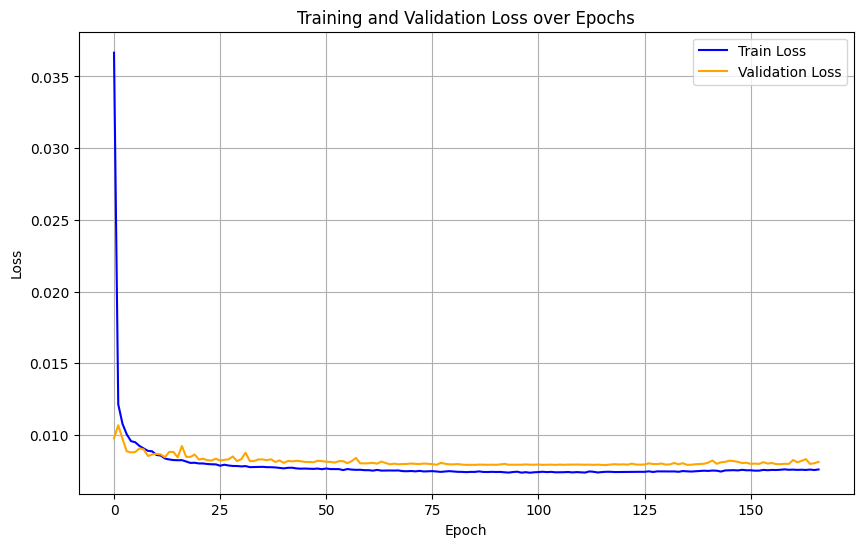

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
def check_and_clip_input(input_df, scaler):
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    columns = scaler.feature_names_in_
    clipped = False
    for i, col in enumerate(columns):
        val = input_df.iloc[0, i]
        if val < min_vals[i] or val > max_vals[i]:
            print(f"Warning: '{col}' value {val} is out of range [{min_vals[i]}, {max_vals[i]}]. Clipping.")
            input_df.iloc[0, i] = min(max(val, min_vals[i]), max_vals[i])
            clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [32]:
# Use a sample from the dataset for inference
new_input = [[734, 0.1575, 25900, 20, 0.98] + [329.386266207629, 352.551499568358, 352.553759702364, 350.275738614983, 339.497145930202, 329.185115858301, 321.851178317625, 319.313289675805, 319.313289675805, 319.313289675805]]
theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = pd.DataFrame(new_input, columns=input_columns)
new_input_df = check_and_clip_input(new_input_df, X_scaler)  # Changed from new_input to new_input_df
new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(new_tensor).cpu().numpy()
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred.flatten().tolist())

All input values are within the training range.

Predicted Temperatures: [355.2514343261719, 356.61138916015625, 358.7702941894531, 360.8740539550781, 361.59423828125, 365.1515197753906, 364.3194274902344, 365.9534912109375, 365.2297058105469, 347.08880615234375]


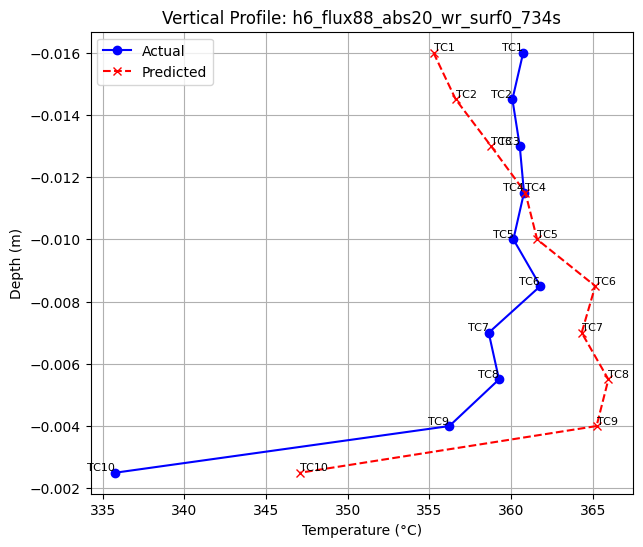

In [33]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    sensor_labels = [f"TC{i+1}" for i in range(10)]
    depths = [-0.016 + i * 0.0015 for i in range(10)]
    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o')
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--')
    plt.gca().invert_yaxis()
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend()

    # Add sensor labels at each point
    for i, label in enumerate(sensor_labels):
        plt.text(actual[i], depths[i], label, ha='right', va='bottom', fontsize=8)
        plt.text(predicted[i], depths[i], label, ha='left', va='bottom', fontsize=8)

    plt.grid(True)
    plt.show()
# Use actual values from the dataset for comparison
actual_values = [360.74, 360.08, 360.53, 360.79, 360.14, 361.79, 358.63, 359.26, 356.22, 335.77]
plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_wr_surf0_734s")

In [ ]:
# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 5
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

